# The 100-layer experiment of linear-relu, relu-linear, linear-relu-linear. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
import math
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set_theme()
import pandas as pd
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_theme()
sns.set_context("talk", ) # paper, notebook, talk, and poster; font_scale=1.5,
from tqdm.notebook import trange, tqdm

In [2]:
def process_with_random_linear_layer(x, dim_size):
    # default: initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
    #             :math:`k = \frac{1}{\text{in\_features}}`
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out = linear_layer(x)
    del linear_layer
    return out


def process_with_linear_ReLu(x, dim_size):
    """ Calculate: Relu(Linear(X)), 
    where linear is init with normal distribution. 
    The function would be called 100 times to simulate an 100-layer network.

    Args:
        x (torch.FloatTensor): batch_size X dim_size
        dim_size (int): the same as the dim_size of x. 

    Returns:
        torch.FloatTensor: the computation result of Relu(Linear(X))
    """
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) )
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
     
    out = linear_layer(x)
    out = torch.nn.functional.relu(out)
    del linear_layer
    return out

def process_with_linear_leaky_relu(x, dim_size):
    """ Calculate: Leaky_ReLu(Linear(X)), 
    where linear is init with normal distribution. 
    The function would be called 100 times to simulate an 100-layer network.

    Args:
        x (torch.FloatTensor): batch_size X dim_size
        dim_size (int): the same as the dim_size of x. 

    Returns:
        torch.FloatTensor: the computation result of Leaky_ReLu(Linear(X))
    """
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out = linear_layer(x)
    out = torch.nn.functional.leaky_relu(out) # by default negative_slope=0.01
    # see https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html
    del linear_layer
    return out



def get_experiment_data(method_name, method_fn, repeat_times=10):
    BATCH_SIZE = 1024 
    DIM_SIZE   = 512 
    LAYER_NUM  = 25

    results_cache = defaultdict(list)
    for exp_repeat_idx in trange(repeat_times): # repeat each experiment 10 times
        print('method:', method_name, 'repeat:', exp_repeat_idx)
        with torch.no_grad():
            # Input X: random Gaussian data
            input_data = torch.randn(BATCH_SIZE, DIM_SIZE, requires_grad=False)
            intermediate_features = [ input_data.detach().cpu().numpy() ]

            x = input_data
            for nn_idx in range(LAYER_NUM):
                x = method_fn(x, DIM_SIZE)
                intermediate_features.append( x.detach().cpu().numpy() )

            assert len(intermediate_features) == 1 + LAYER_NUM
            for num_layers in range(LAYER_NUM+1):
                avg_cos_similarity = feature_pair_wise_similarity(intermediate_features[num_layers], draw_figure=False)
                results_cache['method_name'].append(method_name)
                results_cache['num_layers'].append(num_layers)
                results_cache['avg_cos_similarity'].append(avg_cos_similarity)
    return results_cache

    
def my_norm(x):
    return x/ (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-16)

def feature_pair_wise_similarity(features_np, draw_figure=False):
    """Calculate the cos similarity of all posible input vector pairs, 
    and then average them. 

    Args:
        features_np (np.ndarray): Batch_size X dim_size
        draw_figure (bool, optional): Plot the distribution of the cosine similarity. Defaults to False.

    Returns:
        float: the average cos similarity of (Batch_size X Batch_size) pairs. 
    """
    normed_feature = my_norm(features_np) # Feature
    similarity = normed_feature @ normed_feature.T
    similarity = similarity.ravel().squeeze().tolist()

    x_name = 'Feature cosine pair similarity'
    tmp_df = pd.DataFrame({x_name: similarity})
    if draw_figure:
        print(tmp_df[x_name].describe())
        plt.figure()
        sns.histplot(data=tmp_df, x=x_name)
        plt.plot()
        # plt.close('all')
    return np.mean(similarity)



In [3]:

def process_with_linear_Sigmoid(x, dim_size):
    """ Calculate: Sigmoid(Linear(X)), 
    where linear is init with normal distribution. 
    The function would be called 100 times to simulate an 100-layer network.


    Args:
        x (torch.FloatTensor): batch_size X dim_size
        dim_size (int): the same as the dim_size of x. 

    Returns:
        torch.FloatTensor: the computation result of Sigmoid(Linear(X))
    """
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out = linear_layer(x)
    out = torch.nn.functional.sigmoid(out)
    del linear_layer
    return out



def process_with_linear_Maxout(x, dim_size):
    """ Calculate: Maxout(Linear(X)), 
    where linear is init with normal distribution. 
    The function would be called 100 times to simulate an 100-layer network.

    Ref: Maxout Networks by Goodfellow et al. https://arxiv.org/abs/1302.4389 

    Args:
        x (torch.FloatTensor): batch_size X dim_size
        dim_size (int): the same as the dim_size of x. 

    Returns:
        torch.FloatTensor: the computation result of Maxout(Linear(X))
    """
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out1 = linear_layer(x)
    del linear_layer

    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out2 = linear_layer(x)
    del linear_layer

    out = torch.max(out1, out2)
    return out


def process_with_linear_Tanh(x, dim_size):
    """ Calculate: Tanh(Linear(X)), 
    where linear is init with normal distribution. 
    The function would be called 100 times to simulate an 100-layer network.


    Args:
        x (torch.FloatTensor): batch_size X dim_size
        dim_size (int): the same as the dim_size of x. 

    Returns:
        torch.FloatTensor: the computation result of Tanh(Linear(X))
    """
    linear_layer = nn.Linear(dim_size, dim_size, bias=True) 
    torch.nn.init.normal_(linear_layer.weight, std= 1/ np.sqrt(dim_size) ) 
    torch.nn.init.normal_(linear_layer.bias, std= 1/ np.sqrt(dim_size) ) 
    out = linear_layer(x)
    out = torch.nn.functional.tanh(out)
    del linear_layer
    return out



# New Figure

  0%|          | 0/1 [00:00<?, ?it/s]

method: n*(Linear+Sigmoid) repeat: 0


/home/ubuntu/anaconda3/envs/clip/lib/python3.9/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/1 [00:00<?, ?it/s]

method: n*(Linear+ReLU) repeat: 0


  0%|          | 0/1 [00:00<?, ?it/s]

method: n*(Linear+LeakyReLU) repeat: 0


  0%|          | 0/1 [00:00<?, ?it/s]

method: n*(Linear+Tanh) repeat: 0


/home/ubuntu/anaconda3/envs/clip/lib/python3.9/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  0%|          | 0/1 [00:00<?, ?it/s]

method: n*(Linear) repeat: 0


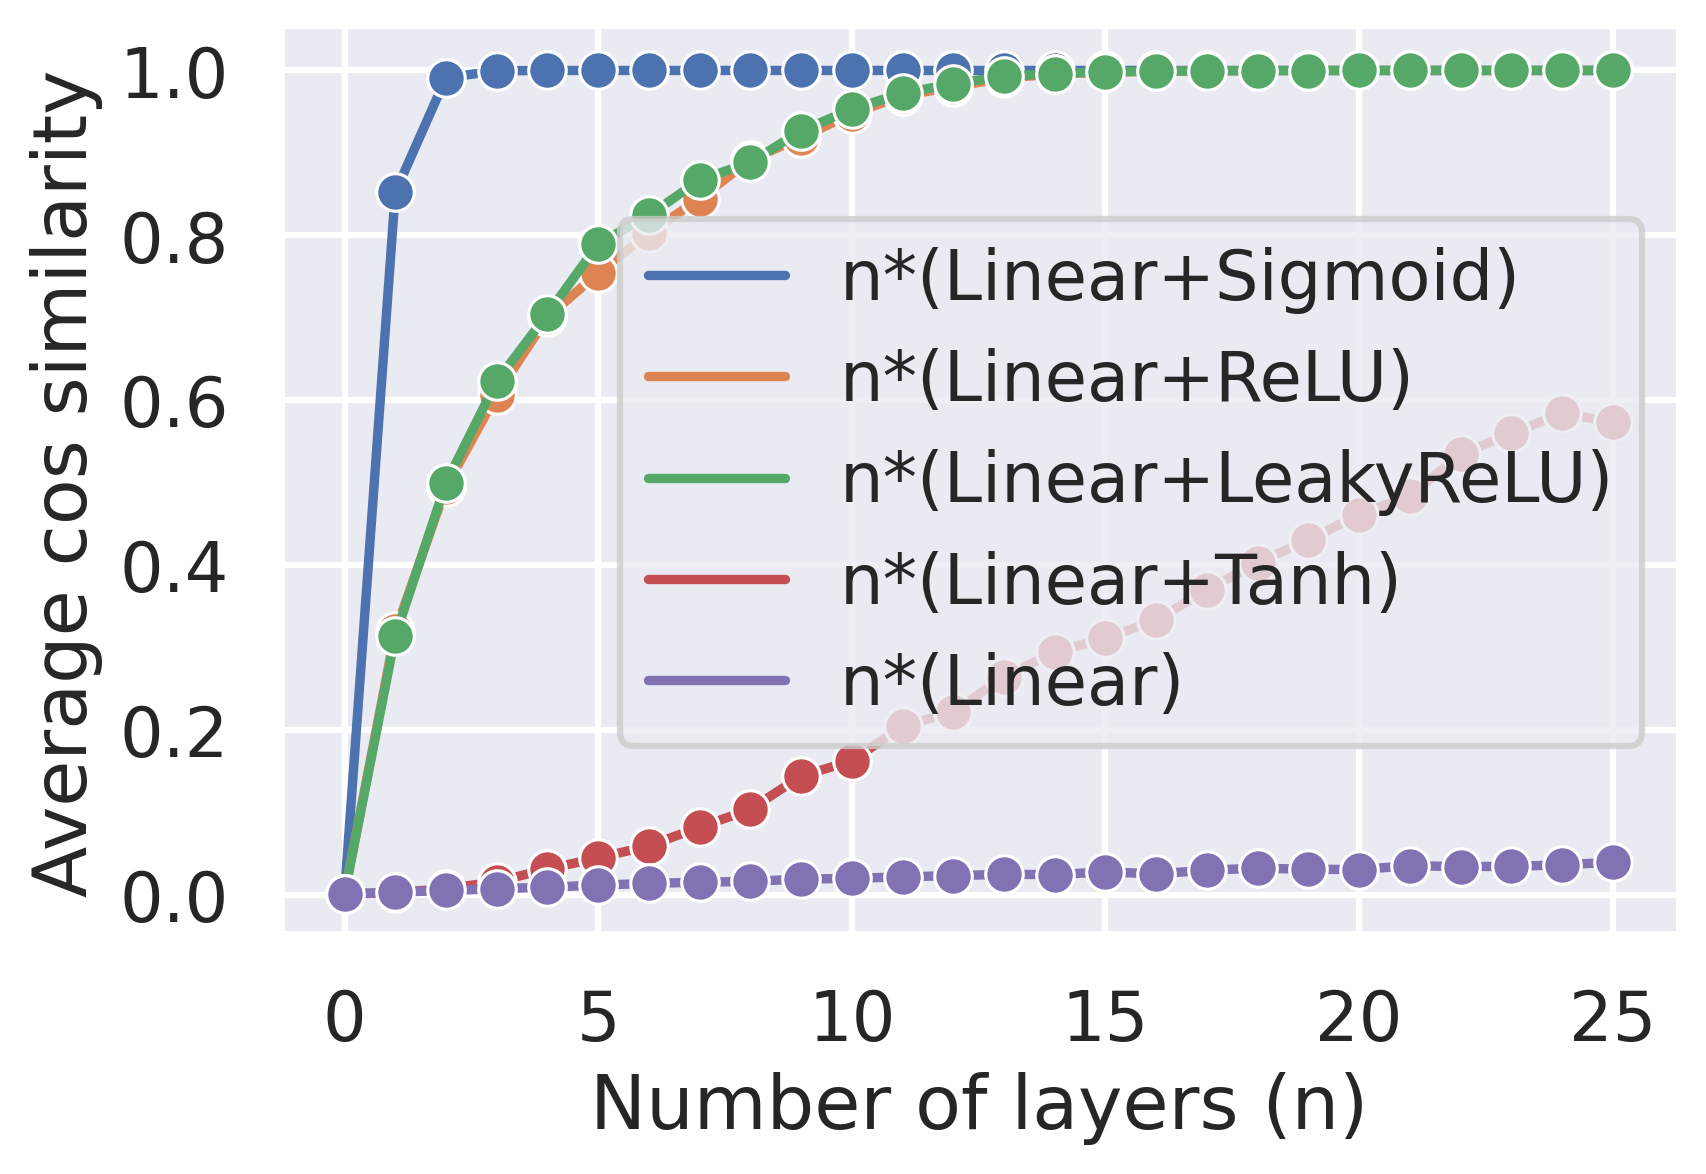

In [4]:
# what we want: a df with network_name, num_layers, and avg_cos value; repeat 10 times to smooth the curve. 

list_results_cache = list()
for method_name, method_fn in [

## Group 1: Output Very Similar to ReLU
['n*(Linear+Sigmoid)', process_with_linear_Sigmoid], # very fast 
['n*(Linear+ReLU)', process_with_linear_ReLu],
['n*(Linear+LeakyReLU)', process_with_linear_leaky_relu],
# ['n*(Linear+Maxout)', process_with_linear_Maxout],
['n*(Linear+Tanh)', process_with_linear_Tanh], # grew slow

## Group 2: only linear
['n*(Linear)', process_with_random_linear_layer],# expected: does not work

## Wierd group
# ['n*(Linear+GELU)', process_with_linear_GELU], # 
# ['n*(Linear+QuickGELU)', process_with_linear_QuickGELU], # similar to real GELU, strange 
# ['n*(Linear+ELU)', process_with_linear_ELU], # slow

]:
    results_cache = get_experiment_data(method_name, method_fn, repeat_times=1)
    list_results_cache.append(results_cache)

results_cache = pd.concat([pd.DataFrame(x) for x in list_results_cache],ignore_index=True)

plt.figure()
sns_plot = sns.lineplot(x="num_layers", y="avg_cos_similarity",
            hue="", marker="o",
            data=pd.DataFrame(results_cache).rename(columns={'method_name': ''}), 
            # kind="line",
            # aspect=11.7/8.27,
            )
# plt.axhline(y=1/np.pi, color="black", linestyle="--") # No line 
sns.despine()
plt.xlabel('Number of layers (n)')
plt.ylabel('Average cos similarity')
plt.show()

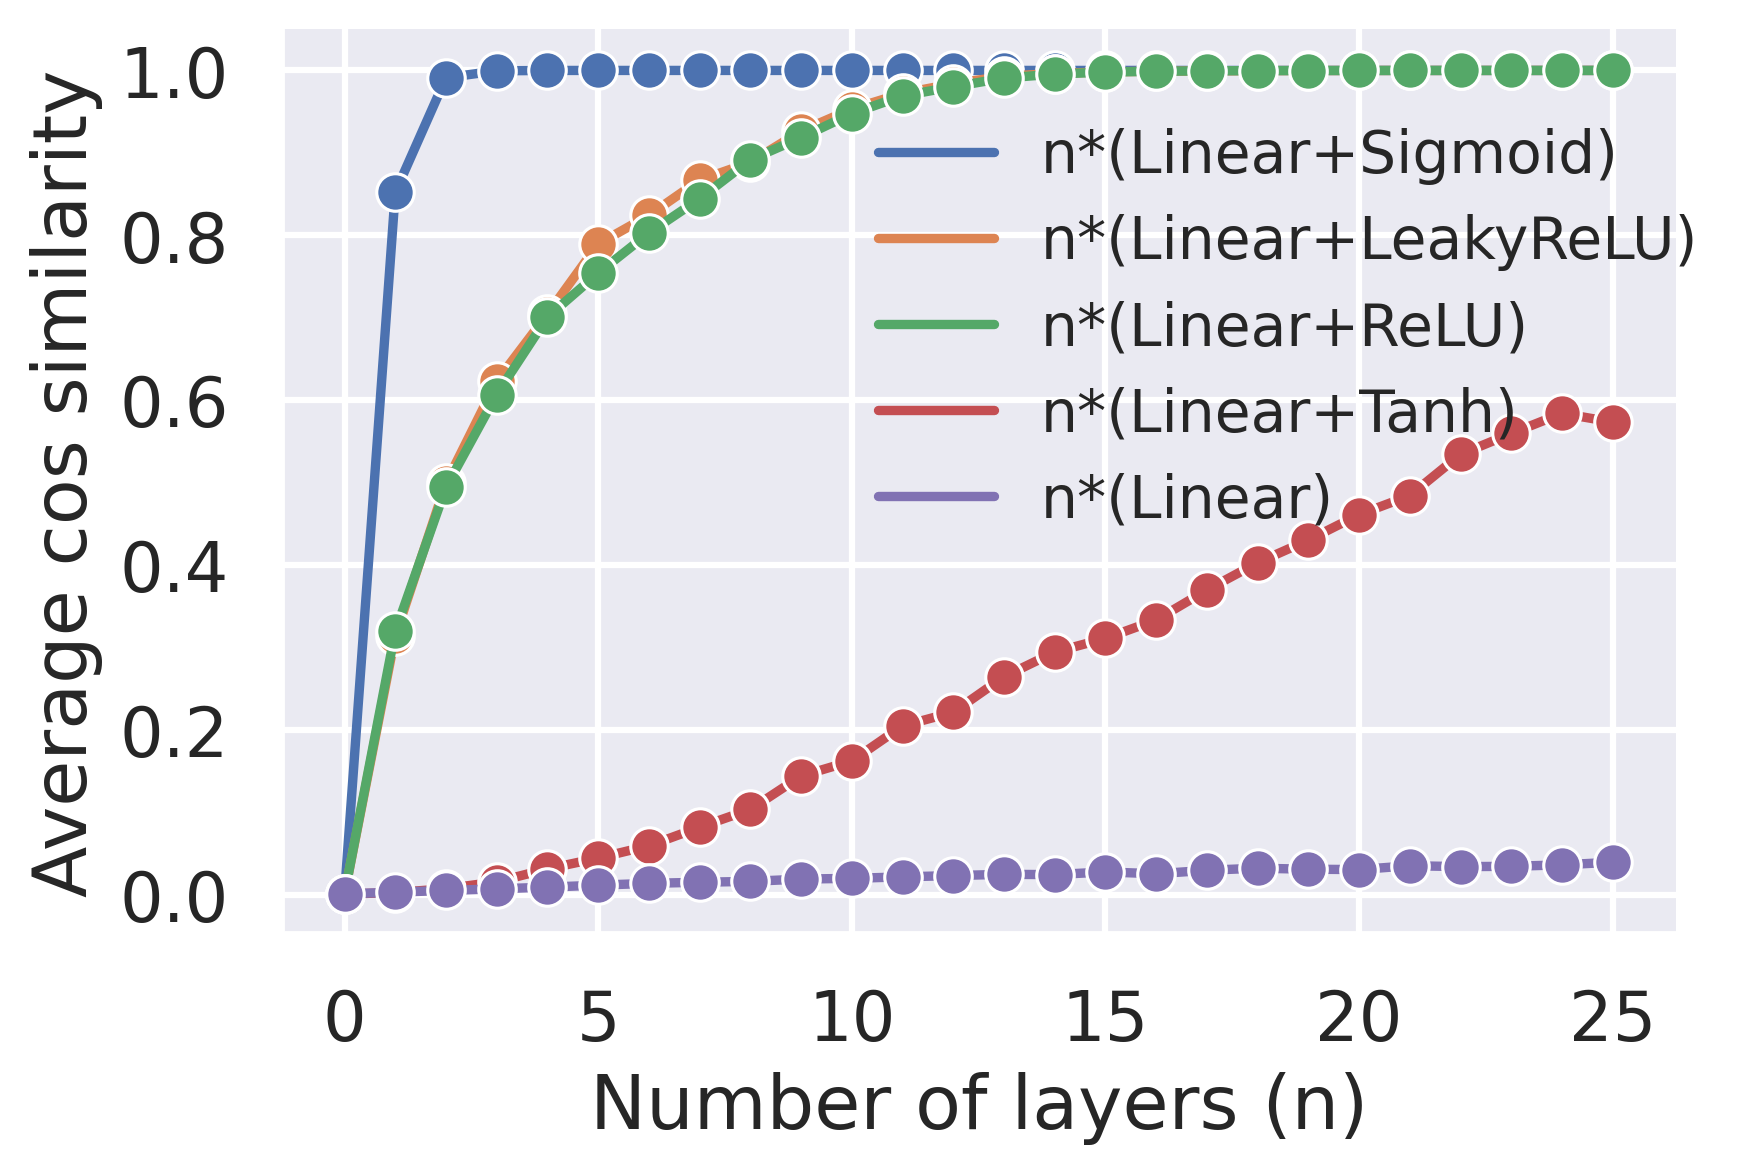

In [5]:
plt.figure()
hue_order = [
    'n*(Linear+Sigmoid)',
    'n*(Linear+LeakyReLU)',
    'n*(Linear+ReLU)',
    'n*(Linear+Tanh)',
    'n*(Linear)',
]
sns_plot = sns.lineplot(x="num_layers", y="avg_cos_similarity",
            hue="", 
            hue_order=hue_order,
            marker="o",
            data=pd.DataFrame(results_cache).rename(columns={'method_name': ''}), 
            )



# plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(0.4,0.95), ) 
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(0.39,0.95), frameon=False) 
sns.despine()
plt.xlabel('Number of layers (n)')
plt.ylabel('Average cos similarity')
plt.show()

In [9]:
results_cache.query("method_name=='n*(Linear+Sigmoid)'")
results_cache.query("method_name=='n*(Linear+ReLU)'")

,method_name,num_layers,avg_cos_similarity
26,n*(Linear+ReLU),0,0.000969
27,n*(Linear+ReLU),1,0.319475
28,n*(Linear+ReLU),2,0.494273
29,n*(Linear+ReLU),3,0.606870
30,n*(Linear+ReLU),4,0.700767
31,n*(Linear+ReLU),5,0.754082
32,n*(Linear+ReLU),6,0.802866
33,n*(Linear+ReLU),7,0.844356
34,n*(Linear+ReLU),8,0.891668
35,n*(Linear+ReLU),9,0.918514
